# Chương 4. HỌC MÁY

## Nhóm Kỹ Thuật Ensemble learning

### Kỹ thuật Voting (Max voting, Averaging và Weighted averaging)

Các mô hình máy học thường bắt đầu từ một giả thuyết nhất định để giải quyết bài toán, ví dụ:
- **Hồi quy tuyến tính** giả định biến phụ thuộc \(Y\) có quan hệ tuyến tính với biến độc lập \(X\).
- **K-NN** giả định các điểm cùng lớp nằm gần nhau.
- **Decision Tree** dựa trên xác suất có điều kiện tại các node.

Tuy nhiên, trong thực tế, mối quan hệ giữa các thuộc tính có thể thay đổi theo thời gian, nên cần một phương pháp kết hợp nhiều mô hình để tăng độ chính xác.

**Ensemble Learning** ra đời từ ý tưởng đó — kết hợp nhiều mô hình yếu để tạo thành một mô hình mạnh hơn.  
Phương pháp này được áp dụng rộng rãi trong các bài toán **phân loại**, **dự báo** và **phân cụm**, và được chia thành hai nhóm:
- **Cơ bản:** Max Voting, Averaging, Weighted Averaging  
- **Nâng cao:** Bagging, Boosting, Stacking

<p align="center">
  <img src="picture/MaxVotingEnsembleLearning.drawio.png" width="600">
  <br>
  <em>Hình 1. Kỹ thuật Max Voting được áp dụng trên n mô hình phân loại, trong đó lớp dự đoán cuối cùng là lớp xuất hiện nhiều nhất trong các dự đoán từ các mô hình.</em>
</p>


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu
col = pd.read_csv('data/College.csv')

# 2. Tiền xử lý
col = col[['Top10perc', 'PhD', 'Terminal', 'perc.alumni', 'Grad.Rate',
           'Top25perc', 'S.F.Ratio', 'Private', 'Expend']]
col['Private'] = col['Private'].map({'Yes': 1, 'No': 0})

# 3. X, y
X = col.drop(columns=['Private'])
y = col['Private']

# 4. Tách dữ liệu thành 2 tập Train/Test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 5. Chuẩn hóa (các mô hình như LR/SVM/KNN cần)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 6. Ensemble Max Voting (Hard Voting)
log_clf = LogisticRegression(max_iter=1000, random_state=42)
svm_clf = SVC(kernel='rbf', random_state=42)          
knn_clf = KNeighborsClassifier(n_neighbors=7)
base_tree = DecisionTreeClassifier(max_depth=5, random_state=42)


Matplotlib is building the font cache; this may take a moment.


In [13]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('svm', svm_clf),
        ('knn', knn_clf),
        ('tree', base_tree),
    ],
    voting='hard',                 # Max voting
    weights=[1, 2, 1, 1]           # ưu tiên SVM (tuỳ chỉnh)
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred_vote)
print(f"Max Voting accuracy: {acc_vote:.4f}")

Max Voting accuracy: 0.8590


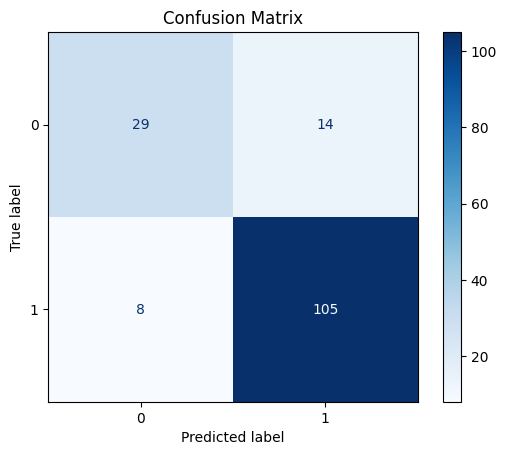

In [ ]:
# Tạo confusion matrix
cm = confusion_matrix(y_test, y_pred_vote)
# Vẽ ma trận confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Kỹ thuật Bagging (Bootstrap Aggregating)

Phương pháp Bootstrap, do Bradley Efron giới thiệu năm 1979, là kỹ thuật lấy mẫu có hoàn lại để tạo nhiều tập dữ liệu có cùng kích thước, giúp ước lượng các đặc trưng của tổng thể như trung bình hay phương sai. Dựa trên kỹ thuật này, Bagging (Bootstrap Aggregating) huấn luyện nhiều mô hình độc lập trên các mẫu Bootstrap khác nhau rồi tổng hợp kết quả dự đoán (bằng Max voting, Average hoặc Weighted averaging). Cách làm này giúp giảm overfitting, giảm phương sai và tăng tính ổn định của mô hình.

<p align="center">
  <img src="picture/Bagging.drawio.png" width="600">
  <br>
  <em>Hình 2. Dữ liệu được chia thành n tập dữ liệu con (subdata) bằng kỹ thuật Bootstrap, sau đó n mô hình được huấn luyện song song. 
  Kết quả dự đoán sẽ được tổng hợp lại để cho kết quả cuối cùng.</em>
</p>

In [21]:
from sklearn.ensemble import BaggingClassifier

# 7. Mô hình Bagging (Bootstrap Aggregating)
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=10,          # số mô hình con (bootstrap models)
    max_samples=0.8,           # mỗi mẫu bootstrap chứa 80% dữ liệu train
    bootstrap=True,            # cho phép lấy mẫu có hoàn lại (Bootstrap)
    random_state=42
)

# Huấn luyện
bagging_clf.fit(X_train, y_train)

# Dự đoán & đánh giá
y_pred_bag = bagging_clf.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)
print(f"Bagging (Bootstrap Aggregating) Accuracy: {acc_bag:.4f}")

Bagging (Bootstrap Aggregating) Accuracy: 0.8333


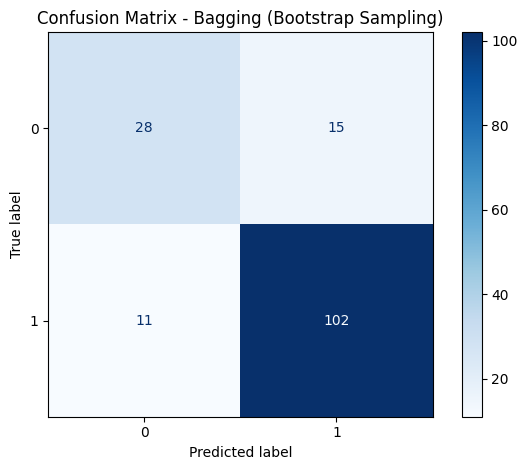

In [ ]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_bag))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Bagging (Bootstrap Sampling)")
plt.tight_layout()
plt.show()

### Kỹ thuật Boosting

Boosting là kỹ thuật học tăng cường trong nhóm Ensemble Learning, được giới thiệu bởi Robert Schapire (1990) và mở rộng trong AdaBoost bởi Yoav Freund và Schapire (1996). Khác với Bagging, nơi các mô hình được huấn luyện song song và độc lập, Boosting huấn luyện tuần tự, trong đó mỗi mô hình mới học từ sai lầm của mô hình trước. Các mẫu khó dự đoán được tăng trọng số để mô hình tập trung hơn vào chúng, giúp cải thiện độ chính xác qua từng vòng lặp. Cuối cùng, các mô hình yếu được kết hợp lại tạo thành một mô hình mạnh hơn.
<p align="center">
  <img src="picture/AdaBoost.drawio.png" width="600">
  <br>
  <em>Hình 3. Kỹ thuật Boosting được áp dụng trên T mô hình phân loại, trong đó lớp dự đoán cuối cùng được tổng hợp lại bằng phép biến đổi tuyến tính.</em>
</p>

#### Thuật toán Adaptive Boosting

AdaBoost (Adaptive Boosting) là kỹ thuật học tăng cường được phát triển và để xuất bởi Yoav Freund và Robert Schapire vào năm 1995. Ý tưởng của AdaBoost là huấn luyện các mô hình yếu một cách tuần tự, các mô hình sau được huấn luyện từ bộ dữ liệu được gán trọng số được tính toán từ mô hình trước, và quá trình được lặp đi lặp lại cho đến khi hiệu suất của các mô hình được cải thiện, các bước để xây dựng thuật toán:

- Bước 1: Khởi tạo trọng số ban đầu.
- Bước 2: Huấn luyện mô hình yếu đầu tiên.
- Bước 3: Tính trọng số của mô hình yếu.
- Bước 4: Cập nhật trong số.
- Bước 5: Lặp lại quy trình từ 2 đến 4.
- Bước 6: Tổng hợp kết quả từ các mô hình yếu.


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. Đọc dữ liệu
card_trans = pd.read_csv('data/card_transdata.csv')

# 2. Tiền xử lý
card_trans['fraud'] = np.where(card_trans['fraud'] == 1.0, 1, -1)
df = pd.DataFrame(card_trans)

# 3. X, y
X = df.drop('fraud', axis=1)  # X
y = df['fraud']  # y

# 4. Tách dữ liệu thành 2 tập Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 5. Khởi tạo mô hình yếu (Weak model)
base_estimator = DecisionTreeClassifier(max_depth=3)  # Decision Stump

# 6. Cài đặt mô hình AdaBoost
adaboost = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=10,  # Số lượng mô hình yếu cài đặt bằng 10
    random_state=42
)

# 7. Huấn luyện mô hình 
adaboost.fit(X_train, y_train)

# 8. Dự đoán
y_pred_ada = adaboost.predict(X_test)

# 9. Đánh giá mô hình
acc_ada = accuracy_score(y_test, y_pred_ada)
print(f"Adaboost accuracy: {acc_ada:.4f}")

Adaboost accuracy: 0.9991


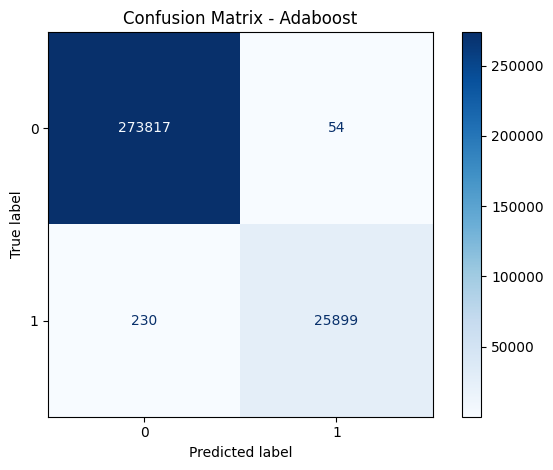

In [10]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ada))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Adaboost")
plt.tight_layout()
plt.show()

#### Thuật toán Gradient Boosting
Gradient Boosting (GradBoosting) là một kỹ thuật học tăng cường trong nhóm Ensemble Learning, được Jerome H. Friedman giới thiệu năm 1999 như phần mở rộng của Boosting. Đây là nền tảng cho các thuật toán mạnh mẽ sau này như XGBoost, LightGBM và CatBoost.

Khác với AdaBoost, GradBoosting không điều chỉnh trọng số dữ liệu ($w_i$) hay gán trọng số cho từng mô hình yếu ($\alpha_t$), mà tập trung tối ưu trực tiếp hàm mất mát theo hướng Gradient Descent — do đó có chữ “Gradient” trong tên gọi. Kết quả cuối cùng vẫn là tổng hợp của nhiều mô hình yếu, thường là cây quyết định có độ sâu từ 8–10, tùy độ phức tạp của dữ liệu. Chi tiết quy trình của GradBoost cho bài toán hồi quy được thực hiện theo các bước sau:
- Bước 1: Khởi tạo mô hình dự đoán đầu tiên $F_0(x)$.
- Bước 2: Huấn luyện mô hình yếu đầu tiên để dự đoán dư lượng giả.
- Bước 3: Cập nhật mô hình từ mô hình yếu trước đó.
- Bước 4: Lặp lại quy trình từ 2 đến 3.
- Bước 5: Tổng hợp được mô hình $F(x)$ cuối cùng.


In [16]:
from sklearn.ensemble import GradientBoostingClassifier


# 6. Cài đặt mô hình Gradient boosting
gb_classifier = GradientBoostingClassifier(
    n_estimators=10,  # Số lượng mô hình yếu
    learning_rate=0.5,  # Learning rate
    max_depth=3,  # Độ sâu tối đa của cây
    random_state=42
)

# 7. Huấn luyện mô hình
gb_classifier.fit(X_train, y_train)

# 8. Dự đoán
y_pred_grad = gb_classifier.predict(X_test)
# 9. Đánh giá mô hình
acc_grad = accuracy_score(y_test, y_pred_ada)
print(f"Adaboost accuracy: {acc_grad:.4f}")

Adaboost accuracy: 0.9991


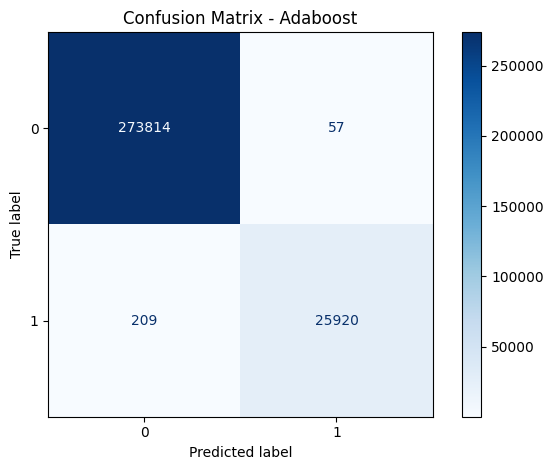

In [17]:
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_grad))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Adaboost")
plt.tight_layout()
plt.show()

#### Thuật toán Extreme Gradient Boosting (XGboost)
Extreme Gradient Boosting (XGBoost) được giới thiệu năm 2014 bởi Tianqi Chen như một phiên bản cải tiến của Gradient Boosting. Thuật toán nhanh chóng nổi bật nhờ giành nhiều chiến thắng tại các cuộc thi Kaggle, ứng dụng hiệu quả trong các bài toán phân lớp và hồi quy như dự đoán hành vi khách hàng, tỷ lệ nhấp quảng cáo, phân loại phần mềm độc hại và dự đoán doanh số. Thành công của XGBoost đến từ nhiều ưu điểm vượt trội sau:
- Khả năng mở rộng linh hoạt trong nhiều bài toán khác nhau
- XGBoost chia nhỏ dữ liệu ra thành nhiều phần cho phép huấn luyện song song trên nhiều lõi CPU và hỗ trợ tối ưu trên GPU giúp tăng tốc độ huấn luyện. 
- Quá trình xây dựng các nhánh trong XGBoost sử dụng phương pháp Histogram-based Splitting để thực hiện rẽ nhanh thay vì xét trên toàn bộ giá trị riêng lẻ giúp quá trình rẽ nhánh nhanh hơn đáng kể và giảm tải bộ nhớ. Lấy ví dụ xét trường dữ liệu độ tuổi khách hàng có các giá trị Age = [23, 34, 45, 56, 89, 21, 90] khi đó ta sẽ sử dụng histogram và tạo thành các bins giúp phân nhóm dữ liệu theo tần suất khi đó ta có bin 1 = [21, 44], bin 2 = [45, 68], bin 3 = [69, 90]. Chú ý rằng cách chia bins cũng ảnh đến độ chính xác của thuật toán, ngoài ra Histogram-based Splitting cũng có thể áp dụng trên các mô hình cây khác.

- Khả năng giải quyết các bài toán với dữ liệu lớn, áp dụng kỹ thuật L1+L2 Regularization và Early Stopping giúp hạn chế vấn đề overfitting.
- Khả năng phân nhánh khi dữ liệu có các điểm missing value mà không cần bước xử lý bên ngoài.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report

# 1.Đọc dữ liệu
card_trans = pd.read_csv('data/card_transdata.csv')

# 2.Tiền xử lý dữ liệu
df = pd.DataFrame(card_trans)
X = df.drop('fraud', axis=1)  # Features
y = df['fraud']  # Target

# 3. Tách dữ liệu thành 2 tập Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_classifier = XGBClassifier(
    n_estimators=10,       # Số lượng mô hình yếu
    learning_rate=0.5,     # Learning rate
    max_depth=3,           # Độ sâu tối đa cho mỗi mô hình yếu
    random_state=42,
    reg_alpha=0.1,         # L1 regularization (Lasso)
    reg_lambda=1.0         # L2 regularization (Ridge)
)

# 4. Huấn luyện mô hình XGBoost
xgb_classifier.fit(X_train, y_train)

# 5. Dự đoán trên tập kiểm thử (test)
y_pred_xgb = xgb_classifier.predict(X_test)

# 6. Đánh giá mô hình
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Adaboost accuracy: {acc_xgb:.4f}")

Adaboost accuracy: 0.9972


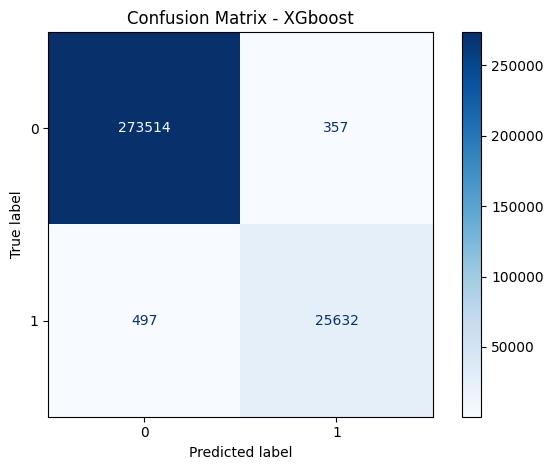

In [ ]:
# Xây dựng ma trận confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGboost")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

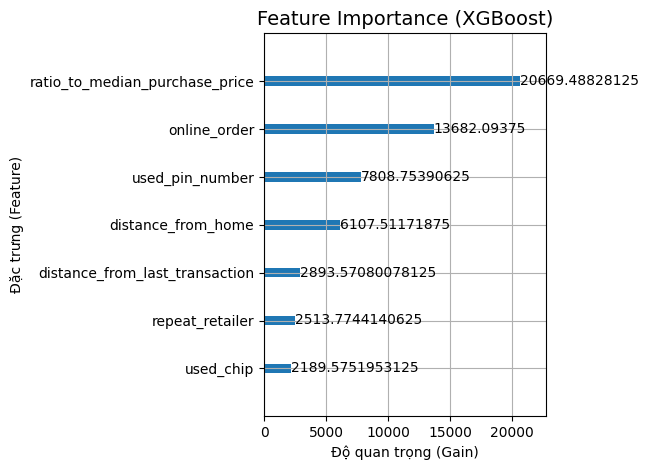

In [24]:
# 7. Vẽ biểu đồ tầm quan trọng của các đặc trưng
plt.figure(figsize=(10, 6))
plot_importance(xgb_classifier, importance_type='gain', show_values=True)
plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Độ quan trọng (Gain)")
plt.ylabel("Đặc trưng (Feature)")
plt.tight_layout()
plt.show()